In [4]:
## Import important module

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
## Generate a Dataset

image_size = (120, 160)
batch_size = 10
class_names = ["cross_leg", "cross_one", "hunch", "lie", "straight"]

# 80% for train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    "../dataset/train_data",
    validation_split=0.2,
    seed = 32,
    subset = "training",
    image_size = image_size,
    batch_size = batch_size,
)

#20% for validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    "../dataset/train_data",
    validation_split=0.2,
    seed = 32,
    subset = "validation",
    image_size = image_size,
    batch_size = batch_size,
)

Found 768 files belonging to 5 classes.
Using 615 files for training.
Found 768 files belonging to 5 classes.
Using 153 files for validation.


In [6]:
## set data augmentation since we don't have enough images and standardize them

data_augmentation = keras.Sequential(
    [   
        layers.Rescaling(1./255),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [26]:
# Build simple CNN model with three convolutional layers

def make_model(num_classes):
    # inputs = keras.Input(shape=input_shape)
    model = keras.Sequential()

    for filter in [32, 64, 72]:
        model.add(layers.Conv2D(filter, 4, strides=2, padding="same", activation="relu"))
        model.add(layers.MaxPooling2D(3, strides=2, padding="same"))

    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.5))
    # final layer with 'num_classes' output
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model
    
model = make_model(num_classes = 5)

In [27]:
## Train the model

epochs = 20

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

check_points = keras.callbacks.ModelCheckpoint("save_best.keras", save_best_only=True),
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=[check_points],
    validation_data=val_ds,
)

Epoch 1/20
62/62 [==============================] - 10s 130ms/step - loss: 1.6171 - accuracy: 0.2049 - val_loss: 20.2848 - val_accuracy: 0.2680
Epoch 2/20
62/62 [==============================] - 8s 114ms/step - loss: 1.6018 - accuracy: 0.2390 - val_loss: 47.1290 - val_accuracy: 0.2680
Epoch 3/20
62/62 [==============================] - 9s 121ms/step - loss: 1.6013 - accuracy: 0.2423 - val_loss: 70.2375 - val_accuracy: 0.2680
Epoch 4/20
62/62 [==============================] - 10s 140ms/step - loss: 1.5695 - accuracy: 0.3154 - val_loss: 97.8632 - val_accuracy: 0.2941
Epoch 5/20
62/62 [==============================] - 11s 152ms/step - loss: 1.3206 - accuracy: 0.4797 - val_loss: 195.1286 - val_accuracy: 0.4575
Epoch 6/20
62/62 [==============================] - 11s 148ms/step - loss: 1.1442 - accuracy: 0.5301 - val_loss: 49.5093 - val_accuracy: 0.7386
Epoch 7/20
62/62 [==============================] - 11s 141ms/step - loss: 0.9600 - accuracy: 0.5886 - val_loss: 84.8020 - val_accuracy: 

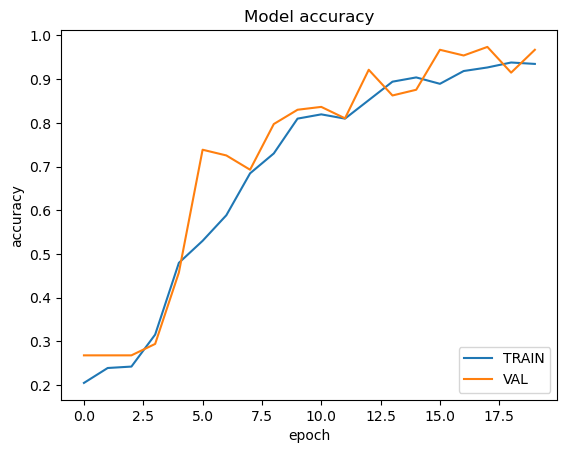

In [34]:
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [19]:
#import header for confusion matrix
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import itertools
from matplotlib import pyplot as plt

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

Found 415 images belonging to 5 classes.
42/42 [==============================] - 49s 1s/step
Confusion matrix, without normalization
              precision    recall  f1-score   support

  cross_legs       0.38      0.09      0.15       118
   cross_one       0.10      0.28      0.14        58
       hunch       0.49      0.49      0.49        69
         lie       0.43      0.36      0.39        94
    straight       0.08      0.08      0.08        76

    accuracy                           0.24       415
   macro avg       0.30      0.26      0.25       415
weighted avg       0.32      0.24      0.25       415



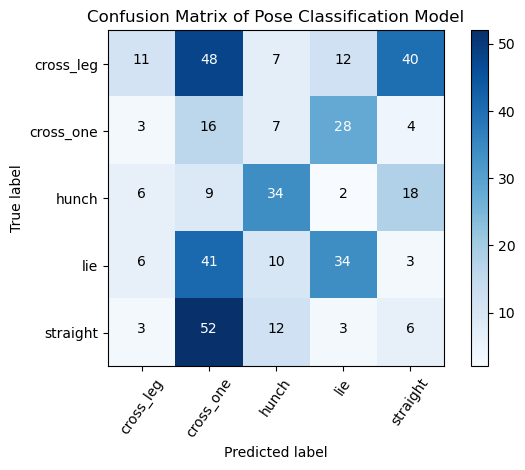

In [28]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    "../dataset/test_data", # Put your path here
     target_size=(image_size[0], image_size[1]),
    batch_size=batch_size,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

predictions = model.predict(test_data_generator)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys()) 

cm = confusion_matrix(true_classes, predicted_classes)
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)